In [42]:
import numpy as np
import operator

In [43]:
def build_link_matrix_A(filename, apply_patch=True):
    """
    Builds the Link Matrix A from a .dat dataset file.
    
    This function handles reading sparse data (edges) and creating 
    the dense or sparse matrix needed for computation. It also manages dangling nodes.
    
    Args:
        filename (str): The path to the .dat file.
        apply_patch (bool): 
            - If True: Applies the "Patch" to dangling nodes. Replaces zero columns
              with 1/N. Returns a perfectly STOCHASTIC matrix A'.
              (Useful if you want to simulate the pure 'random surfer' behavior).
            - If False: Leaves zero columns intact. Returns a SUBSTOCHASTIC A.
              (This is the method used in the original paper and requires final normalization
               at the end of the PageRank calculation to compensate for mass loss).
                            
    Returns:
        tuple: (A, N)
            - A (numpy.ndarray): The constructed N x N matrix.
            - N (int): The total number of nodes (pages), useful for creating subsequent vectors.
    """
    
    links = []
    
    # =========================================================================
    # --- PART 1: FILE READING AND PRE-PROCESSING ---
    # =========================================================================
    try:
        with open(filename, 'r') as file:
            
            # 1. Read Header
            # The file starts with "N M" (Nodes, Edges). We need N to size the matrix.
            header_line = file.readline().strip().split()
            if not header_line or len(header_line) < 2:
                raise ValueError("The file must start with a valid 'N M' line.")
            
            num_nodes = int(header_line[0])
            N = num_nodes  # Size of the square matrix (N x N)
            
            # 2. Skip URL mapping lines
            # The first N lines after the header are URLs (strings). 
            # For the math, we only need numeric IDs, so we skip them.
            print(f"Skipping the first {num_nodes} URL mapping lines...")
            for _ in range(num_nodes):
                file.readline()
            
            # 3. Process the edges (Links)
            # Dictionary to count how many links exit each page (Out-Degree, n_j).
            # Used to calculate the transition probability (1 / n_j).
            out_degree = {} 
            valid_link_count = 0
            
            for line in file:
                parts = line.strip().split()
                # We expect lines made of "Source_ID Target_ID"
                if len(parts) == 2:
                    try:
                        source_id = int(parts[0])
                        target_id = int(parts[1])
                        
                        # Count the out-degree for the source node
                        out_degree[source_id] = out_degree.get(source_id, 0) + 1
                        
                        # Store the edge for later processing
                        links.append((source_id, target_id))
                        valid_link_count += 1
                    except ValueError:
                        # Robust handling for malformed lines
                        continue
                        
            print(f"Read {valid_link_count} valid edges.")

    except Exception as e:
        print(f"Error processing the file: {e}")
        return None, 0

    if N == 0:
        return None, 0

    # =========================================================================
    # --- PART 2: BASIC CONSTRUCTION OF A (The Link Matrix) ---
    # =========================================================================
    
    # Create an N x N matrix filled with zeros.
    A = np.zeros((N, N))

    # Populate the matrix using the read edges.
    # Rule: A[i, j] = 1 / n_j  (where j=source, i=destination)
    for source_id, target_id in links:
        # Convert from ID (base-1, from file) to Index (base-0, for Python)
        source_idx = source_id - 1  # Column j
        target_idx = target_id - 1  # Row i
        
        # Recover n_j (how many links exit the source node)
        n_j = out_degree.get(source_id, 0)
        
        # Safety check on indices and division by zero
        if 0 <= source_idx < N and 0 <= target_idx < N and n_j > 0:
            A[target_idx, source_idx] = 1.0 / n_j

    # At this point, if a node has no outgoing links (so, it is dangling node),
    # its column is entirely ZERO. (Substochastic Matrix).

    # =========================================================================
    # --- PART 3: APPLYING THE PATCH (Optional) ---
    # =========================================================================
    if apply_patch:
        print("Applying PATCH to dangling nodes (Transformation A -> A')...")
        dangling_count = 0
        
        # Value to insert: uniform probability distributed over N nodes
        patch_value = 1.0 / N
        
        # Scan all columns (source nodes)
        for j in range(N):
            # Check if it is a Dangling Node (out_degree = 0)
            # Note: we use j+1 because the dictionary keys are base-1 IDs
            if out_degree.get(j + 1, 0) == 0:
                
                # THE FIX: Replace the zero column with 1/N.
                # Physically means: "If you arrive here, jump to a random page".
                A[:, j] = patch_value
                dangling_count += 1
                
        print(f"Patch applied to {dangling_count} dangling nodes out of {N} total.")
        print("The resulting matrix is now perfectly column-stochastic (column sums = 1).")
    else:
        print("No patch applied.")
        print("The matrix remains substochastic (dangling node columns sum to 0).")
        print("NOTE: The PageRank algorithm will need to use final normalization to work correctly.")
    print(f"Link matrix {N}x{N} ready for calculation.")
    return A, N

In [44]:
def calculate_pagerank(L_matrix, m=0.15, max_iter=200, tolerance=1e-7):
    """
    Compute the PageRank using the Power Method.
    
    This function implements the iterative formula:
    x(k+1) = (1 - m) * A * x(k) + m * s
    
    Args:
        L_matrix (numpy.ndarray): The Link Matrix A (N x N). Can be substochastic (dangling nodes).
        m (float): Teleportation probability (e.g., 0.15). (1-m) is the Damping Factor (0.85).
        max_iter (int): Maximum number of iterations to avoid infinite loops.
        tolerance (float): Convergence threshold. If the difference between two iterations is less than this, we stop.
        
    Returns:
        tuple: (PageRank_eigenvector, number_of_iterations)
    """
    
    # 1. Determine the size of the Web (N)
    # L_matrix.shape[0] returns the number of rows (nodes).
    n = L_matrix.shape[0]
    
    # 2. Create the Teleportation vector (s)
    # It is a column vector where each element is 1/N.
    # Represents the uniform probability that the user lands on a random page.
    s = np.full((n, 1), 1/n)
    
    # 3. Initialization of the PageRank vector (x)
    # At the beginning (t=0), we assume all pages have the same importance (1/N).
    x = np.full((n, 1), 1/n)
    
    # Variable to count the actual iterations
    k = 0
    
    # --- START POWER METHOD ---
    for k in range(max_iter):
        
        # Save the vector from the previous iteration to compare later
        x_prev = x.copy()
        
        # --- STEP A: Navigation through Links ---
        # Calculate A * x. 
        # Here the probability flows through the existing links.
        # Note: L_matrix is sparse (has many zeros), so this operation is fast.
        Ax = L_matrix @ x_prev
        
        # --- STEP B: Application of the Google formula (Implicit M) ---
        # Formula: x_new = (1-m) * (Link) + m * (Teleportation)
        # (1 - m) * Ax : The probability that follows the links (e.g., 85%)
        # m * s        : The probability that is redistributed everywhere (e.g., 15%)
        # This step simulates the multiplication by the matrix M without having to build it.
        x = (1 - m) * Ax + m * s
        
        # --- STEP C: Convergence Check ---
        # Calculate the L1 Norm of the difference (sum of absolute differences).
        # If the vector has changed very little compared to the previous iteration, we have found equilibrium.
        diff = np.sum(np.abs(x - x_prev))
        
        if diff < tolerance:
            # Exit the for loop early if we have convergence
            break
            
    # --- END POWER METHOD ---

    # 4. Final Normalization (Crucial for Dangling Nodes)
    # If L_matrix did not have the patch (had zero columns), we lost some probability
    # at each iteration (the sum of x will be < 1, e.g., 0.85).
    # This division brings the sum exactly to 1.0, maintaining the correct proportions.
    x_normalized = x / np.sum(x)
    
    # Returns the final eigenvector (normalized) and the number of iterations taken (k+1 because k starts at 0)
    return x_normalized, k + 1

In [45]:
# --- Example 1: Web with 4 pages (Figure 2.1) ---
print("=============================================")
print("  EXECUTION: WEB WITH 4 PAGES (FIGURE 2.1) ")
print("=============================================")

A_4pages = np.array([
    [0.0, 0.0, 1.0, 0.5],
    [1/3, 0.0, 0.0, 0.0],
    [1/3, 0.5, 0.0, 0.5],
    [1/3, 0.5, 0.0, 0.0]
])

pagerank_scores_4pages,iterations_4pages = calculate_pagerank(A_4pages, m=0.15)

# Preparazione dei risultati: lista di tuple (ID pagina, Punteggio)
page_indices_4pages = np.arange(1, A_4pages.shape[0] + 1)
results_4pages = list(zip(page_indices_4pages, pagerank_scores_4pages.flatten()))
results_4pages_sorted = sorted(results_4pages, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_4pages_sorted:
    print(f"Pagina {page_id}: {score:.4f}")
    
print(f"Calculation completed in {iterations_4pages} iterations.")

# --- Example 2: Web with 5 pages (Figure 2.2) ---
print("\n\n=============================================")
print("  EXECUTION: WEB WITH 5 PAGES (FIGURE 2.2) ")
print("=============================================")


A_5pages = np.array([
    [0.0, 1.0, 0.0, 0.0, 0.0],   # Links TO page 1 (from 2)
    [1.0, 0.0, 0.0, 0.0, 0.0],   # Links TO page 2 (from 1)
    [0.0, 0.0, 0.0, 1.0, 0.5],   # Links TO page 3 (from 4, 5)
    [0.0, 0.0, 1.0, 0.0, 0.5],   # Links TO page 4 (from 3, 5)
    [0.0, 0.0, 0.0, 0.0, 0.0]    # Links TO page 5 (none)
])

# Calculation of PageRank
pagerank_scores_5pages,iterations_5pages = calculate_pagerank(A_5pages, m=0.15)

# Preparation of results: list of tuples (Page ID, Score)
page_indices_5pages = np.arange(1, A_5pages.shape[0] + 1)
results_5pages = list(zip(page_indices_5pages, pagerank_scores_5pages.flatten()))
results_5pages_sorted = sorted(results_5pages, key=operator.itemgetter(1), reverse=True)


for page_id, score in results_5pages_sorted:
    print(f"Page {page_id}: {score:.4f}")
    
print(f"Calculation completed in {iterations_5pages} iterations.")

  EXECUTION: WEB WITH 4 PAGES (FIGURE 2.1) 
Pagina 1: 0.3682
Pagina 3: 0.2880
Pagina 4: 0.2021
Pagina 2: 0.1418
Calculation completed in 21 iterations.


  EXECUTION: WEB WITH 5 PAGES (FIGURE 2.2) 
Page 3: 0.2850
Page 4: 0.2850
Page 1: 0.2000
Page 2: 0.2000
Page 5: 0.0300
Calculation completed in 2 iterations.


In [ ]:
# Calculation of PageRank on the hollins.dat dataset

filename = 'hollins.dat'
m=0.15 
top_k=10

# 1. CONSTRUCTION OF THE LINK MATRIX A 
A_matrix, N_nodes = build_link_matrix_A(filename)

# 2. CALCULATION OF PAGERANK
pagerank_scores, iterations = calculate_pagerank(A_matrix, m=m)

print(f"Calculation completed in {iterations} iterations.")
# 3. PREPARATION AND PRINTING OF RESULTS
page_ids = np.arange(1, N_nodes + 1)
results = list(zip(page_ids, pagerank_scores.flatten()))

# Sorting by score in descending order
results_sorted = sorted(results, key=operator.itemgetter(1), reverse=True)

print(f"\n--- TOP {top_k} Pages Ranking (out of {N_nodes} total) ---")

# Print the top K results
for rank, (page_id, score) in enumerate(results_sorted[:top_k], 1):
    # NOTE: For a real project, here you should look up the URL
    # corresponding to the page ID from section 1 of the file.
    print(f"Rank {rank}: Page ID {page_id} (Score: {score:.6f})")
print("-------------------------------------------------------")

# ADDITIONAL INFORMATION (Useful for the report)
# For a good evaluation, you might print the importance of the least important node
# which should approach the theoretical minimum score (m/N).
min_score = results_sorted[-1][1]
expected_min = m / N_nodes
print(f"Minimum score (last page): {min_score:.6f}")
print(f"Theoretical minimum score ({m}/N): {expected_min:.6f}")

Skipping the first 6012 URL mapping lines...
Read 23875 valid edges.
Applying PATCH to dangling nodes (Transformation A -> A')...
Patch applied to 3189 dangling nodes out of 6012 total.
The resulting matrix is now perfectly column-stochastic (column sums = 1).
Link matrix 6012x6012 ready for calculation.
Calculation completed in 71 iterations.

--- TOP 10 Pages Ranking (out of 6012 total) ---
Rank 1: Page ID 2 (Score: 0.019879)
Rank 2: Page ID 37 (Score: 0.009288)
Rank 3: Page ID 38 (Score: 0.008610)
Rank 4: Page ID 61 (Score: 0.008065)
Rank 5: Page ID 52 (Score: 0.008027)
Rank 6: Page ID 43 (Score: 0.007165)
Rank 7: Page ID 425 (Score: 0.006583)
Rank 8: Page ID 27 (Score: 0.005989)
Rank 9: Page ID 28 (Score: 0.005572)
Rank 10: Page ID 4023 (Score: 0.004452)
-------------------------------------------------------
Minimum score (last page): 0.000058
Theoretical minimum score (0.15/N): 0.000025


In [47]:
import numpy as np
import operator

# Setting m = 0.0 in the function calculate_pagerank is mathematically equivalent to using "formula (2.1)" from the PDF,
# which calculates the ranking based on the pure link matrix A without any teleportation.

print("=============================================")
print("                 EXERCISE 1")
print("=============================================")

# ---------------------------------------------------------
# 1. Original Situation (4 Pages)
# ---------------------------------------------------------
print("\n--- 1. Original Situation (4 Pages) ---")

A_orig = np.array([
    [0.0, 0.0, 1.0, 0.5],  
    [1/3, 0.0, 0.0, 0.0],  
    [1/3, 0.5, 0.0, 0.5],  
    [1/3, 0.5, 0.0, 0.0]   
])

# m=0.0 to use formula (2.1) Ax = x
scores_orig, iters_orig = calculate_pagerank(A_orig, m=0.0, max_iter=1000)

# Print Original Results
indices_orig = np.arange(1, A_orig.shape[0] + 1)
results_orig = list(zip(indices_orig, scores_orig.flatten()))
results_orig_sorted = sorted(results_orig, key=operator.itemgetter(1), reverse=True)

print("Original Ranking:")
for page_id, score in results_orig_sorted:
    print(f"Page {page_id}: {score:.4f}")

p1_score_orig = scores_orig[0][0]
p3_score_orig = scores_orig[2][0]


# ---------------------------------------------------------
# 2. Modified Situation (5 Pages)
# ---------------------------------------------------------
print("\n--- 2. Modified Situation (5 Pages) ---")
print("Modification: Added Page 5. Links: 3->5 and 5->3.")

# Modified A Matrix (5x5)
A_mod = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0],  
    [1/3, 0.0, 0.0, 0.0, 0.0],  
    [1/3, 0.5, 0.0, 0.5, 1.0],  
    [1/3, 0.5, 0.0, 0.0, 0.0],  
    [0.0, 0.0, 0.5, 0.0, 0.0]   
])

scores_mod, iters_mod = calculate_pagerank(A_mod, m=0.0, max_iter=1000)

# Print Modified Results
indices_mod = np.arange(1, A_mod.shape[0] + 1)
results_mod = list(zip(indices_mod, scores_mod.flatten()))
results_mod_sorted = sorted(results_mod, key=operator.itemgetter(1), reverse=True)

print(f"Calculation completed in {iters_mod} iterations.")
print("Modified Ranking (m=0):")
for page_id, score in results_mod_sorted:
    print(f"Page {page_id}: {score:.4f}")

p1_score_mod = scores_mod[0][0]
p3_score_mod = scores_mod[2][0]

# ---------------------------------------------------------
# FINAL CHECK
# ---------------------------------------------------------
print("\n=============================================")
print(" RESULTS CHECK")
print("=============================================")
print(f"BEFORE: Page 1 ({p1_score_orig:.4f}) vs Page 3 ({p3_score_orig:.4f})")
print(f"AFTER:  Page 1 ({p1_score_mod:.4f}) vs Page 3 ({p3_score_mod:.4f})")

if p3_score_mod > p1_score_mod:
    print("\nANSWER: YES. The strategy worked.")
else:
    print("\nANSWER: NO.")

                 EXERCISE 1

--- 1. Original Situation (4 Pages) ---
Original Ranking:
Page 1: 0.3871
Page 3: 0.2903
Page 4: 0.1935
Page 2: 0.1290

--- 2. Modified Situation (5 Pages) ---
Modification: Added Page 5. Links: 3->5 and 5->3.
Calculation completed in 49 iterations.
Modified Ranking (m=0):
Page 3: 0.3673
Page 1: 0.2449
Page 5: 0.1837
Page 4: 0.1224
Page 2: 0.0816

 RESULTS CHECK
BEFORE: Page 1 (0.3871) vs Page 3 (0.2903)
AFTER:  Page 1 (0.2449) vs Page 3 (0.3673)

ANSWER: YES. The strategy worked.


In [48]:
print("=============================================")
print(" EXERCISE 11: PAGERANK CALCULATION ON MODIFIED NETWORK")
print(" (Eigenvector of M with m=0.15)")
print("=============================================")

# ---------------------------------------------------------
# DEFINITION OF THE WEB (5 PAGES)
# ---------------------------------------------------------
# Exercise specification:
# - Base: Figure 2.1 (4 pages)
# - Addition: Page 5
# - Link: 5 -> 3
# - Link: 3 -> 5 (in addition to its original links)

A_ex11 = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0],  
    [1/3, 0.0, 0.0, 0.0, 0.0],  
    [1/3, 0.5, 0.0, 0.5, 1.0],  
    [1/3, 0.5, 0.0, 0.0, 0.0],  
    [0.0, 0.0, 0.5, 0.0, 0.0]   
])

# ---------------------------------------------------------
# CALCULATION (Find the eigenvector of M)
# ---------------------------------------------------------
# The exercise asks to use m = 0.15
# Our function calculate_pagerank exactly solves x = Mx
scores_ex11, iters_ex11 = calculate_pagerank(A_ex11, m=0.15)

# ---------------------------------------------------------
# RESULTS VISUALIZATION
# ---------------------------------------------------------
print(f"\nCalculation converged in {iters_ex11} iterations.")
print("Final Ranking (Normalized Eigenvector):")

indices_ex11 = np.arange(1, 6) # Pages from 1 to 5
results_ex11 = list(zip(indices_ex11, scores_ex11.flatten()))
results_ex11_sorted = sorted(results_ex11, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_ex11_sorted:
    print(f"Page {page_id}: {score:.4f}")

# Specific check implicitly requested by comparison with Ex 1
p1 = scores_ex11[0][0]
p3 = scores_ex11[2][0]
print(f"\nKey Comparison:")
print(f"Page 3 ({p3:.4f}) > Page 1 ({p1:.4f})?")
print("YES" if p3 > p1 else "NO")

 EXERCISE 11: PAGERANK CALCULATION ON MODIFIED NETWORK
 (Eigenvector of M with m=0.15)

Calculation converged in 33 iterations.
Final Ranking (Normalized Eigenvector):
Page 3: 0.3489
Page 1: 0.2371
Page 5: 0.1783
Page 4: 0.1385
Page 2: 0.0972

Key Comparison:
Page 3 (0.3489) > Page 1 (0.2371)?
YES


In [49]:
print("=============================================")
print(" EXERCISE 12: PAGE WITHOUT BACKLINKS")
print("=============================================")

A_ex12 = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0, 0.2], 
    [1/3, 0.0, 0.0, 0.0, 0.0, 0.2], 
    [1/3, 0.5, 0.0, 0.5, 1.0, 0.2], 
    [1/3, 0.5, 0.0, 0.0, 0.0, 0.2], 
    [0.0, 0.0, 0.5, 0.0, 0.0, 0.2], 
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Row Pg 6 (No backlinks -> Backlinks = 0)
])

# ---------------------------------------------------------
# CALCULATION 1: USING ONLY A (m=0.0)
# ---------------------------------------------------------
print("\n--- CASE A: Ranking with m=0.0 (Only Link) ---")
scores_A, iters_A = calculate_pagerank(A_ex12, m=0.0, max_iter=1000)

results_A = list(zip(np.arange(1, 7), scores_A.flatten()))
results_A_sorted = sorted(results_A, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_A_sorted:
    print(f"Page {page_id}: {score:.4f}")

# ---------------------------------------------------------
# CALCULATION 2: USING M (m=0.15)
# ---------------------------------------------------------
print("\n--- CASE B: Ranking with m=0.15 (Google Model) ---")
scores_M, iters_M = calculate_pagerank(A_ex12, m=0.15)

results_M = list(zip(np.arange(1, 7), scores_M.flatten()))
results_M_sorted = sorted(results_M, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_M_sorted:
    print(f"Page {page_id}: {score:.4f}")

# ---------------------------------------------------------
# CHECK PAGE 6
# ---------------------------------------------------------
print("\nCheck Page 6 (No Backlink):")
print(f"With m=0.00 -> Score: {scores_A[5][0]:.6f} (Should be 0)")
print(f"With m=0.15 -> Score: {scores_M[5][0]:.6f} (Minimum guaranteed = 0.15/6 = 0.025)")

 EXERCISE 12: PAGE WITHOUT BACKLINKS

--- CASE A: Ranking with m=0.0 (Only Link) ---
Page 3: 0.3673
Page 1: 0.2449
Page 5: 0.1837
Page 4: 0.1224
Page 2: 0.0816
Page 6: 0.0000

--- CASE B: Ranking with m=0.15 (Google Model) ---
Page 3: 0.3402
Page 1: 0.2312
Page 5: 0.1738
Page 4: 0.1350
Page 2: 0.0948
Page 6: 0.0250

Check Page 6 (No Backlink):
With m=0.00 -> Score: 0.000000 (Should be 0)
With m=0.15 -> Score: 0.025000 (Minimum guaranteed = 0.15/6 = 0.025)


In [50]:
print("=============================================")
print(" EXERCISE 13: DISCONNECTED SUBNETWORKS")
print("=============================================")

# ---------------------------------------------------------
# CONSTRUCTION OF THE MATRIX (5 PAGES, 2 SUBNETWORKS)
# ---------------------------------------------------------

# (No links between group {1,2} and group {3,4,5})

A_ex13 = np.array([
    [0.0, 1.0,   0.0, 0.0, 0.0], 
    [1.0, 0.0,   0.0, 0.0, 0.0], 
    
    [0.0, 0.0,   0.0, 1.0, 1.0], 
    [0.0, 0.0,   0.5, 0.0, 0.0], 
    [0.0, 0.0,   0.5, 0.0, 0.0]  
])

print("Matrix A (5x5) constructed with two disconnected components.")
print("Group A: Pages 1-2")
print("Group B: Pages 3-4-5")

# ---------------------------------------------------------
# CALCULATION WITH FORMULA 3.1 (m=0.15)
# ---------------------------------------------------------

# Teleportation allows jumping from one island to another.

print("\n--- Ranking Calculation (m=0.15) ---")
scores_13, iters_13 = calculate_pagerank(A_ex13, m=0.15)

results_13 = list(zip(np.arange(1, 6), scores_13.flatten()))
results_13_sorted = sorted(results_13, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_13_sorted:
    group = "Gruppo A" if page_id <= 2 else "Gruppo B"
    print(f"Pagina {page_id} ({group}): {score:.4f}")

# ---------------------------------------------------------
# ANALYSIS OF THE SUM BY GROUPS
# ---------------------------------------------------------
sum_group_A = np.sum(scores_13[0:2])
sum_group_B = np.sum(scores_13[2:5])

print("\n--- Probability Distribution Analysis ---")
print(f"Total Probability Group A (2 pages): {sum_group_A:.4f}")
print(f"Total Probability Group B (3 pages): {sum_group_B:.4f}")
print(f"Approximate Expected Ratio (2/5 vs 3/5):")
print(f"A: {2/5:.4f}, B: {3/5:.4f}")

 EXERCISE 13: DISCONNECTED SUBNETWORKS
Matrix A (5x5) constructed with two disconnected components.
Group A: Pages 1-2
Group B: Pages 3-4-5

--- Ranking Calculation (m=0.15) ---
Pagina 3 (Gruppo B): 0.2919
Pagina 1 (Gruppo A): 0.2000
Pagina 2 (Gruppo A): 0.2000
Pagina 4 (Gruppo B): 0.1541
Pagina 5 (Gruppo B): 0.1541

--- Probability Distribution Analysis ---
Total Probability Group A (2 pages): 0.4000
Total Probability Group B (3 pages): 0.6000
Approximate Expected Ratio (2/5 vs 3/5):
A: 0.4000, B: 0.6000


In [51]:
# 1. CONSTRUCTION OF THE GOOGLE MATRIX M (Formula 3.1 of the paper)
# Normalized adjacency matrix A (Exercise 11)
A = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0], 
    [1/3, 0.0, 0.0, 0.0, 0.0], 
    [1/3, 0.5, 0.0, 0.5, 1.0], 
    [1/3, 0.5, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.5, 0.0, 0.0]  
])

# Parameters from the paper
m = 0.15          # Teleportation probability
N = 5             # Web size
S = np.full((N, N), 1/N) # Uniform teleportation matrix

# Formula (3.1): M = (1-m)A + mS
M = (1 - m) * A + m * S

# 2. CALCULATION OF THE EXACT STATIONARY STATE (q)
# Calculated using eigenvectors to have a reference for the error
eigenvalues, eigenvectors = np.linalg.eig(M)
idx_q = np.argmin(np.abs(eigenvalues - 1.0))
q = np.real(eigenvectors[:, idx_q])
q = q / np.sum(q) # Normalization (Sum = 1)
q = q.reshape(-1, 1)

# 3. APPLICATION OF THE POWER METHOD (x_k = M * x_k-1)
# Initial probability vector x0 (All mass on Page 1)
x = np.array([[1.0], [0.0], [0.0], [0.0], [0.0]])

print(f"{'Iter (k)':<10} | {'L1 Error (e_k)':<20} | {'Ratio (e_k/e_k-1)':<20}")
print("-" * 60)

prev_error = np.sum(np.abs(x - q))

for k in range(1, 51):
    x = M @ x  # Random Surfer iterative step
    curr_error = np.sum(np.abs(x - q))
    ratio = curr_error / prev_error
    
    # Print the checkpoints required by the paper
    if k in [1, 5, 10, 50]:
        print(f"{k:<10} | {curr_error:<20.10f} | {ratio:<20.10f}")
    
    prev_error = curr_error

# 4. CALCULATION OF THE THEORETICAL PARAMETERS FROM THE PAPER
# Ergodicity Coefficient c(M)
# Formula: max_j | 1 - 2 * min_i M_ij |
min_entries_per_column = np.min(M, axis=0)
c_M = np.max(np.abs(1 - 2 * min_entries_per_column))

# Second Dominant Eigenvalue |lambda_2|
abs_eigenvalues = np.sort(np.abs(eigenvalues))[::-1]
lambda_2 = abs_eigenvalues[1]

print("-" * 60)
print(f"THEORETICAL RESULTS:")
print(f"Second Dominant Eigenvalue |lambda_2|:   {lambda_2:.6f}")
print(f"Ergodicity Coefficient c(M):  {c_M:.6f}")
print(f"\nCheck Proposition 4: |lambda_2| <= c(M) is {lambda_2 <= c_M}")
print(f"Check Convergence: Final ratio ({ratio:.4f}) tends to |lambda_2| ({lambda_2:.4f})")

Iter (k)   | L1 Error (e_k)       | Ratio (e_k/e_k-1)   
------------------------------------------------------------
1          | 0.7819626529         | 0.5125208082        
5          | 0.0068714107         | 0.3227085474        
10         | 0.0003043717         | 0.5245287480        
50         | 0.0000000000         | 0.6112802965        
------------------------------------------------------------
THEORETICAL RESULTS:
Second Dominant Eigenvalue |lambda_2|:   0.611269
Ergodicity Coefficient c(M):  0.940000

Check Proposition 4: |lambda_2| <= c(M) is True
Check Convergence: Final ratio (0.6113) tends to |lambda_2| (0.6113)


Second eigenvalue: 0.6113
Theoretical limit (1-m): 0.8500


<>:49: SyntaxWarning: invalid escape sequence '\l'
<>:49: SyntaxWarning: invalid escape sequence '\l'
C:\Users\lisav\AppData\Local\Temp\ipykernel_6628\678841067.py:49: SyntaxWarning: invalid escape sequence '\l'
  plt.semilogy(steps, theoretical_decay, 'r--', label=f'Theoretical Decay ($|\lambda_2|^k$)')


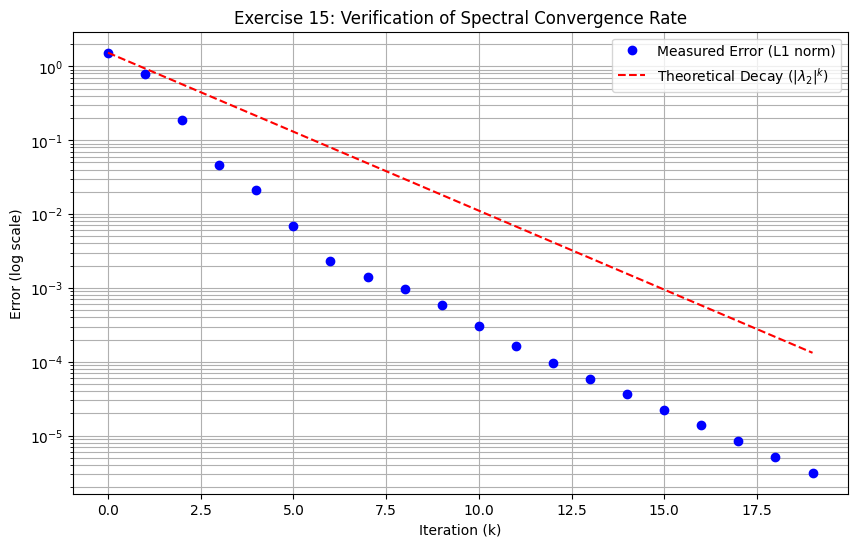

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP 
A = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0], 
    [1/3, 0.0, 0.0, 0.0, 0.0], 
    [1/3, 0.5, 0.0, 0.5, 1.0], 
    [1/3, 0.5, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.5, 0.0, 0.0]  
])
m = 0.15
N = 5
M = (1 - m) * A + m * np.full((N, N), 1/N)

# 2. CALCULATION OF EIGENVALUES AND STATIONARY STATE
eigenvalues, eigenvectors = np.linalg.eig(M)

# Sort eigenvalues by magnitude
abs_ev = np.sort(np.abs(eigenvalues))[::-1]
lambda_1 = abs_ev[0] # Should be 1.0
lambda_2 = abs_ev[1] # The second eigenvalue

# q is the eigenvector corresponding to lambda_1
idx_q = np.argmin(np.abs(eigenvalues - 1.0))
q = np.real(eigenvectors[:, idx_q])
q = (q / np.sum(q)).reshape(-1, 1)

# 3. POWER METHOD SIMULATION AND ERROR COLLECTION
x = np.array([[1.0], [0.0], [0.0], [0.0], [0.0]])
errors = []
theoretical_decay = []

steps = range(20)
initial_error = np.sum(np.abs(x - q))

for k in steps:
    curr_error = np.sum(np.abs(x - q))
    errors.append(curr_error)

    # Theoretical formula: e_k = e_0 * (lambda_2^k)
    theoretical_decay.append(initial_error * (lambda_2**k))

    x = M @ x

# 4. PLOT OF RESULTS
plt.figure(figsize=(10, 6))
plt.semilogy(steps, errors, 'ob', label='Measured Error (L1 norm)')
plt.semilogy(steps, theoretical_decay, 'r--', label=f'Theoretical Decay ($|\lambda_2|^k$)')

plt.title('Exercise 15: Verification of Spectral Convergence Rate')
plt.xlabel('Iteration (k)')
plt.ylabel('Error (log scale)')
plt.grid(True, which="both", ls="-")
plt.legend()

print(f"Second eigenvalue: {lambda_2:.4f}")
print(f"Theoretical limit (1-m): {1-m:.4f}")
plt.show()